In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

In [18]:
stock_symbol = 'MARUTI.NS'
stock_data = yf.download(stock_symbol,  period="max")

[*********************100%%**********************]  1 of 1 completed


In [19]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-07-09,164.899994,170.399994,155.000000,164.300003,143.867996,35164284
2003-07-10,167.000000,168.699997,164.500000,167.000000,146.232239,10464179
2003-07-11,167.750000,174.850006,166.250000,173.350006,151.792587,11740117
2003-07-14,174.250000,179.250000,174.250000,177.949997,155.820526,5982324
2003-07-15,200.000000,200.000000,173.000000,176.199997,154.288162,6173689
...,...,...,...,...,...,...
2024-04-25,12964.000000,12980.700195,12740.349609,12922.500000,12922.500000,640725
2024-04-26,12922.000000,13045.000000,12660.000000,12703.349609,12703.349609,704626
2024-04-29,12800.049805,12994.799805,12603.000000,12689.849609,12689.849609,613937


In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


stock_data.reset_index(inplace=True)

# Extract the 'Date' and 'Close' columns
data = stock_data[['Date', 'Close']].copy()

In [21]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# Function to create dataset
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back)])
        y.append(data[i + look_back, 0])  # Close price is the label (index 0)
    return np.array(X), np.array(y)

# Create dataset with look-back window
look_back = 60  # Adjust this window size as needed
X, y = create_dataset(scaled_data, look_back)

# Reshape input data for LSTM (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [22]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [23]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X, y, epochs=50, batch_size=32)

Epoch 1/50
160/160 [==============================] - 7s 14ms/step - loss: 0.0048
Epoch 2/50
160/160 [==============================] - 2s 14ms/step - loss: 0.0018
Epoch 3/50
160/160 [==============================] - 2s 12ms/step - loss: 0.0016
Epoch 4/50
160/160 [==============================] - 2s 12ms/step - loss: 0.0014
Epoch 5/50
160/160 [==============================] - 2s 12ms/step - loss: 0.0012
Epoch 6/50
160/160 [==============================] - 2s 12ms/step - loss: 0.0011
Epoch 7/50
160/160 [==============================] - 2s 14ms/step - loss: 0.0010
Epoch 8/50
160/160 [==============================] - 2s 14ms/step - loss: 0.0011
Epoch 9/50
160/160 [==============================] - 2s 12ms/step - loss: 0.0010
Epoch 10/50
160/160 [==============================] - 2s 12ms/step - loss: 9.2881e-04
Epoch 11/50
160/160 [==============================] - 2s 12ms/step - loss: 9.9813e-04
Epoch 12/50
160/160 [==============================] - 2s 12ms/step - loss: 8.8171e-04
E

1/1 [==============================] - 0s 25ms/step


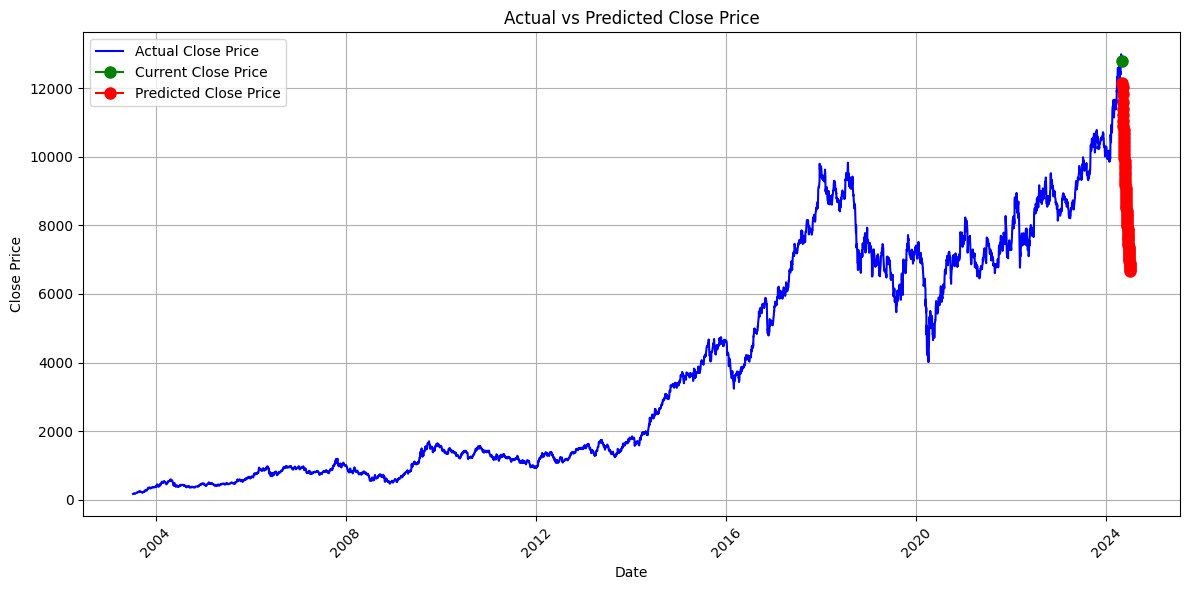

In [24]:
def predict_future_prices(model, data, look_back, num_days):
    last_sequence = data[-look_back:]  # Get the last sequence of known data
    predicted_prices = []
    for _ in range(num_days):
        prediction = model.predict(last_sequence.reshape(1, look_back, 1))  # Predict next day's price
        predicted_prices.append(prediction[0, 0])  # Append predicted price to list
        last_sequence = np.append(last_sequence[1:], prediction[0])  # Update last sequence with new prediction
    return scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))[:, 0]

# Predict future prices for the next 20 days
num_days = 60  # Change this value to predict a different number of days into the future
predicted_prices = predict_future_prices(model, scaled_data, look_back, num_days)

# Plot actual and predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], scaler.inverse_transform(scaled_data), label='Actual Close Price', color='blue')
plt.plot(data['Date'].iloc[-1:], scaler.inverse_transform(scaled_data)[-1:], marker='o', markersize=8, color='green', label='Current Close Price')
plt.plot(pd.date_range(start=data['Date'].iloc[-1], periods=num_days+1, freq='D')[1:], predicted_prices, marker='o', markersize=8, color='red', label='Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
predicted_prices

array([12154.054 , 12027.796 , 11825.949 , 11605.681 , 11398.805 ,
       11216.456 , 11057.874 , 10917.379 , 10788.66  , 10666.765 ,
       10548.567 , 10432.486 , 10317.949 , 10204.923 , 10093.578 ,
        9984.112 ,  9876.668 ,  9771.323 ,  9668.1   ,  9566.98  ,
        9467.929 ,  9370.896 ,  9275.826 ,  9182.661 ,  9091.338 ,
        9001.796 ,  8913.97  ,  8827.798 ,  8743.218 ,  8660.171 ,
        8578.601 ,  8498.453 ,  8419.677 ,  8342.225 ,  8266.051 ,
        8191.112 ,  8117.3687,  8044.7817,  7973.3154,  7902.9355,
        7833.6084,  7765.3027,  7697.988 ,  7631.636 ,  7566.2197,
        7501.7114,  7438.0864,  7375.3203,  7313.39  ,  7252.273 ,
        7191.948 ,  7132.394 ,  7073.5913,  7015.5215,  6958.166 ,
        6901.507 ,  6845.5273,  6790.2114,  6735.543 ,  6681.5073],
      dtype=float32)

In [28]:
model.save('Maruti_NS.h5')

In [27]:
import joblib
joblib.dump(scaler, 'Maruti_NS_minmax_scaler.pkl')

['Maruti_NS_minmax_scaler.pkl']